# Cross Validation Station Selection

Below is the same code as station_selection, but altered to find the stations that will be used for the cross validation parameter calculations. Clusters were slightly expanded, and data was filtered to only keep stations that have readings from 2014-2023. 20 stations were selected, attempting to give us a wide variety of locations across Washington.

In [1]:
# import general libraries for data exploration and cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import seaborn as sns
import datetime as dt
%matplotlib inline

# Geo plotting imports
import geopandas as gpd

# set style parameters for graphs
sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13
plt.rcParams['figure.dpi'] = 300

# Import libraries for sql connection
import mysql.connector
import pickle
import warnings

warnings.filterwarnings('ignore')

# Load credentials for login (hidden and not added to repo)
with open("login_cred.pkl", "rb") as fp:
    config = pickle.load(fp)
    print('Credentials Loaded')
    
cnx = mysql.connector.connect(**config) # connection point

Credentials Loaded


In [2]:
# Query DB to get station ID and number of records
count_q = ("""SELECT station_id, count(*) as nRecords 
              FROM raw_awn_records
              GROUP BY station_id
              ORDER BY nRecords DESC;""")

s_count = pd.read_sql(count_q, cnx)

# Query DB to get station information
info_q = ("""SELECT station_id, state, county, active_station, station_latdeg, station_lngdeg, station_elevation
             FROM stations_awn
             WHERE active_station LIKE 'Y' """)

s_info = pd.read_sql(info_q, cnx)

stations = pd.merge(s_count, s_info, on='station_id')

In [28]:
# Define cluster areas from above graph (these can be changed as needed)
cluster_areas = {
    'C1': {
        'lat': [48.5, 49.4],
        'long': [-121.3, -123.2]
    },
    'C2': {
        'lat': [48.2, 49.5],
        'long': [-117.8, -120.0]
    },
    'C3': {
        'lat': [45.0, 46.2],
        'long': [-120.2, -122.3]
    },
    'C4': {
        'lat': [45.7, 47.0],
        'long': [-116.2, -117.9]
    },
    'C5': {
        'lat': [46.2, 47.9],
        'long': [-118.5, -121]
    }
}

# Empty data frame to hold stations in red boxes above
df = pd.DataFrame()

# Create data frame of potential stations (take top 4 from each - assuming one of these will work)
for c in cluster_areas: # iterate over C1, ..., C5
    cluster = cluster_areas[c] # get lat/long dict
    lat1, lat2 = cluster['lat'][0], cluster['lat'][1] # get latitude
    long1, long2 = cluster['long'][0], cluster['long'][1] # get longitude
    
    # Query data filtered by latitude and longitude values
    q = stations.query(f'{lat1} <= station_latdeg <= {lat2} and {long1} >= station_lngdeg >= {long2} and station_id != 64')
    
    q = q.sort_values(by=['nRecords'], ascending=False) # sort by number of records
    q = q.iloc[:5] # take top 4 stations (in terms of number of records)
    df = pd.concat([df, q], ignore_index=True) # append to data frame

In [29]:
df = df[df.nRecords > 300000] # ensure large span of years (2014-2023)

In [30]:
# Import map shapes
map_o = gpd.read_file('map_shp/oregon/cb_2018_41_bg_500k.shp') # read in oregon state shape
map_w = gpd.read_file('map_shp/washington/cb_2018_53_bg_500k.shp') # read in washington state shape
map_i = gpd.read_file('map_shp/idaho/cb_2018_16_bg_500k.shp') # read in idaho state shape

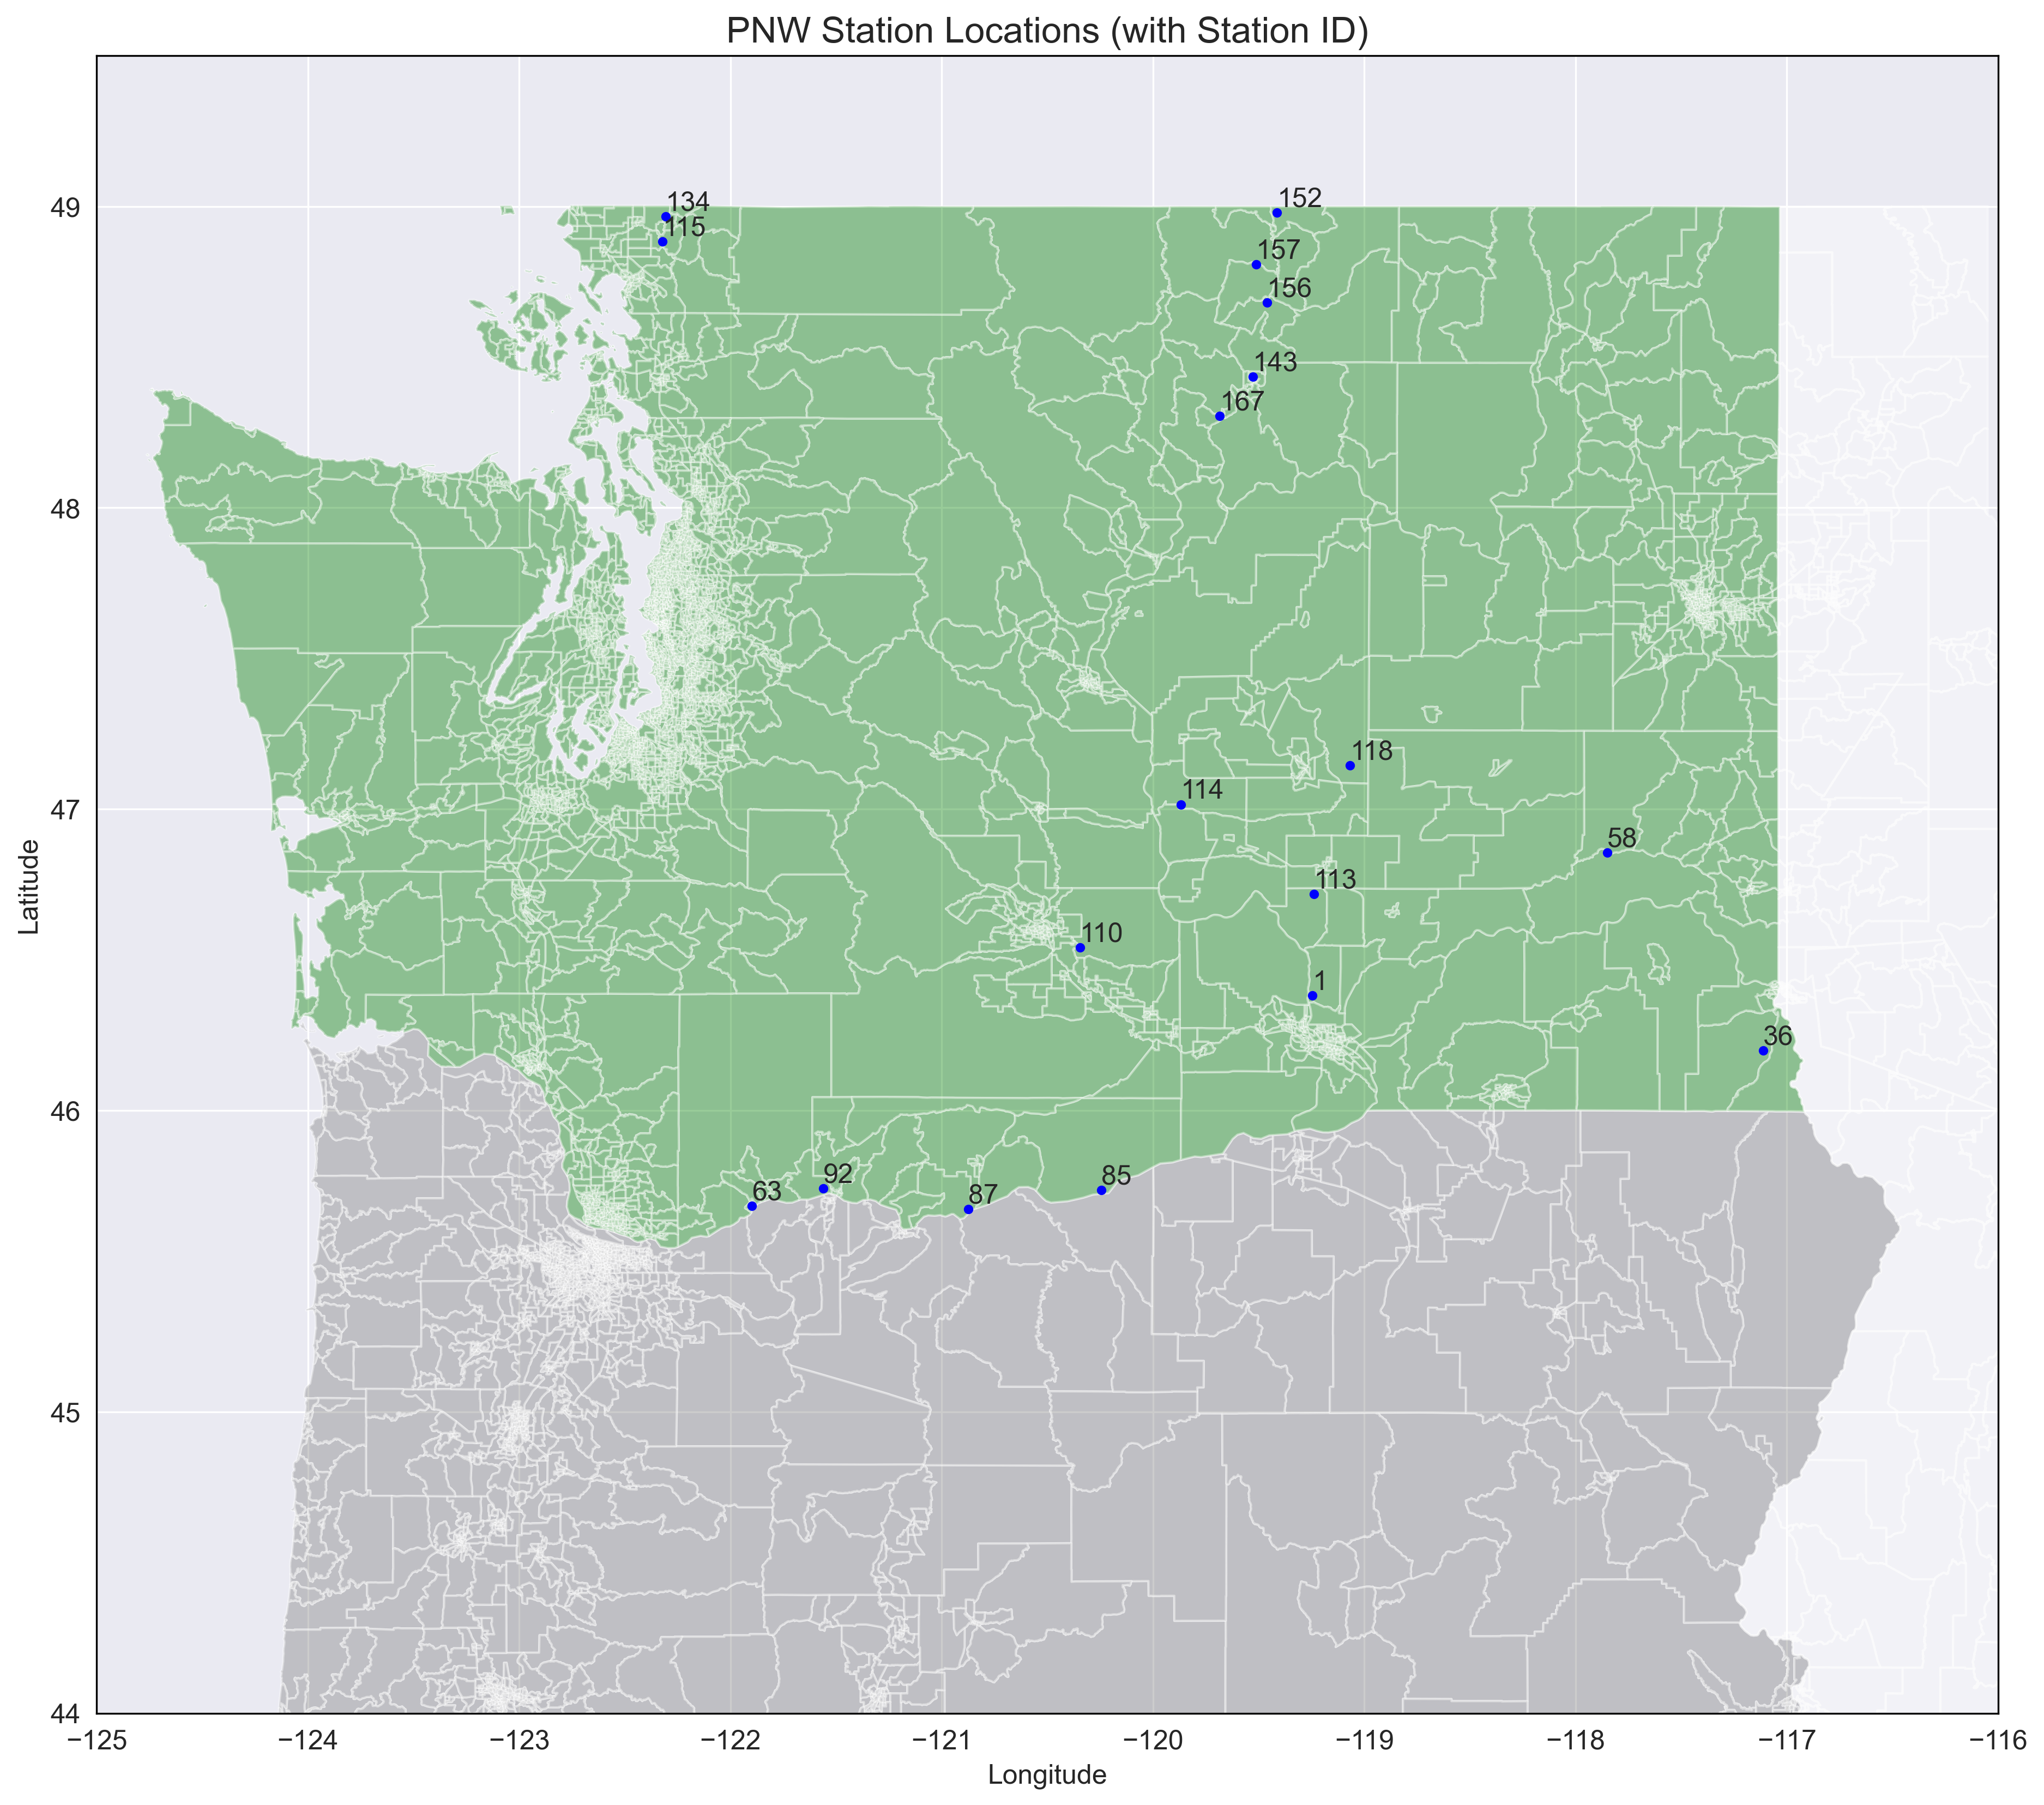

In [31]:
fig, ax = plt.subplots(figsize=(15,15))

map_o.plot(ax=ax, alpha=0.4, color='grey') # oregon (grey)
map_w.plot(ax=ax, alpha=0.4, color='green') # washington (green)
map_i.plot(ax=ax, alpha=0.4, color='white') # idaho (white)
plt.scatter(df.station_lngdeg, df.station_latdeg, c='b', s=10)
for i in range(df.shape[0]):
    plt.text(df.station_lngdeg.values[i], df.station_latdeg.values[i]+0.02, df.station_id.values[i])
plt.xlim(-125, -116)
plt.ylim(44, 49.5)

plt.title('PNW Station Locations (with Station ID)')
plt.xlabel('Longitude')
plt.ylabel("Latitude")
plt.show();

In [32]:
df.station_id.values # list of stations to be used in cross validation

array([115, 134, 143, 152, 156, 157, 167,  63,  85,  87,  92,  36,  58,
         1, 110, 113, 114, 118])